# Water Meter usecase with AutoML for Images

(Object Detection task) and Azure OCR

<img src="https://github.com/retkowsky/AutoMLforImages/blob/main/images/snapshot%20water%20meter.jpg?raw=true" width=600>

## 1. Setup
> To use this notebook, **you will need to install the private preview package for AutoML for Images from the private index**.

In [35]:
#!pip install --upgrade "azureml-train-core<0.1.1" "azureml-train-automl<0.1.1" "azureml-contrib-dataset<0.1.1" --extra-index-url "https://azuremlsdktestpypi.azureedge.net/automl_for_images_private_preview/"

In [36]:
import numpy as np
import json
import os
import urllib
import seaborn as sns
import pandas as pd
import cv2 as cv

from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import RandomParameterSampling
from azureml.train.hyperdrive import GridParameterSampling
from azureml.train.hyperdrive import choice

In [37]:
import sys
print("Python version =", sys.version)

Python version = 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [38]:
import datetime
now = datetime.datetime.now()
print("Today =", now)

Today = 2021-06-22 12:22:41.161708


In [39]:
import azureml.core
print("You are using Azure ML version", azureml.core.VERSION)

You are using Azure ML version 0.1.0.36994775


In [40]:
# Your local platform
import platform,socket,re,uuid,json,psutil,logging

def getSystemInfo():
    try:
        info={}
        info['Platform']=platform.system()
        info['Platform-release']=platform.release()
        info['Platform-version']=platform.version()
        info['Architecture']=platform.machine()
        info['Hostname']=socket.gethostname()
        info['IP-address']=socket.gethostbyname(socket.gethostname())
        info['MAC-address']=':'.join(re.findall('..', '%012x' % uuid.getnode()))
        info['Processor']=platform.processor()
        info['RAM']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" Go"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)

json.loads(getSystemInfo())

{'Platform': 'Linux',
 'Platform-release': '5.4.0-1047-azure',
 'Platform-version': '#49~18.04.1-Ubuntu SMP Thu Apr 22 21:28:54 UTC 2021',
 'Architecture': 'x86_64',
 'Hostname': 'computeinstancenbooks',
 'IP-address': '127.0.0.1',
 'MAC-address': '17:51:c8:59:f5:32',
 'Processor': 'x86_64',
 'RAM': '14 Go'}

## 2. Azure ML workspace setup
In order to train and deploy models in Azure ML, you will first need to set up a workspace.

An [Azure ML Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#workspace) is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML Workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, deployment, inference, and the monitoring of deployed models.

Create an Azure ML Workspace within your Azure subscription, or load an existing workspace.

In [41]:
## specify Azure ML workspace parameters
subscription_id='tobereplaced'   
resource_group='automlvision-rg'   
workspace_name='automlvision'

from azureml.core.workspace import Workspace
ws = Workspace.create(name=workspace_name,
                      subscription_id=subscription_id,
                      resource_group=resource_group, 
                      exist_ok=True)

In [42]:
from azureml.core import Workspace
ws = Workspace.from_config()

In [43]:
print("Azure ML Workspace =", ws.name, "\nAzure ML Resource Group =", ws.resource_group)

Azure ML Workspace = automlvision 
Azure ML Resource Group = automlvision-rg


## 3. GPU Compute target setup
You will need to provide a [Compute Target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) that will be used for your AutoML model training. AutoML models for image tasks require GPU SKUs and support NC and ND families. We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [44]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = "gpu-watermeter"

try:
    compute_target = ws.compute_targets[cluster_name]
    print('Found existing compute target.')
except KeyError:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC24', 
                                                           idle_seconds_before_scaledown=1800,
                                                           min_nodes=0, 
                                                           max_nodes=4)

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
    
# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

Found existing compute target.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [45]:
# Compute cluster status
compute_target.provisioning_state

'Succeeded'

In [46]:
# Compute cluster information
compute_target.get_status().serialize()

{'currentNodeCount': 0,
 'targetNodeCount': 0,
 'nodeStateCounts': {'preparingNodeCount': 0,
  'runningNodeCount': 0,
  'idleNodeCount': 0,
  'unusableNodeCount': 0,
  'leavingNodeCount': 0,
  'preemptedNodeCount': 0},
 'allocationState': 'Steady',
 'allocationStateTransitionTime': '2021-06-22T10:31:29.613000+00:00',
 'errors': None,
 'creationTime': '2021-06-22T09:42:22.202145+00:00',
 'modifiedTime': '2021-06-22T09:43:02.800172+00:00',
 'provisioningState': 'Succeeded',
 'provisioningStateTransitionTime': None,
 'scaleSettings': {'minNodeCount': 0,
  'maxNodeCount': 4,
  'nodeIdleTimeBeforeScaleDown': 'PT1800S'},
 'vmPriority': 'Dedicated',
 'vmSize': 'STANDARD_NC24'}

In [47]:
compute_target.vm_size

'STANDARD_NC24'

## 4. Experiment Setup
Create an [Experiment](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiment) in your workspace to track your model training runs

In [48]:
from azureml.core import Experiment

experiment_name = 'AutomlImages-WaterMeter' 
experiment = Experiment(ws, name=experiment_name)

In [49]:
experiment

Experiment(Name: AutomlImages-WaterMeter,
Workspace: automlvision)

## 5. Dataset with input Training Data
In order to generate models for computer vision, you will need to bring in labeled image data as input for model training in the form of an AzureML Labeled Dataset. You can either use a Labeled Dataset that you have exported from a Data Labeling project, or create a new Labeled Dataset with your labeled training data

Steps for labelling the images:

1. Save all the images into an Azure Blob Storage
2. Define a datastore from Azure ML Portal that links to your blob storage
3. Create a Data Labelling project task for object detection in order to tag the consumption index region
4. Once the Data labelling task is done, export the results into an Azure ML dataset. The next step is using the labelled dataset

In [50]:
# We can call the labelled dataset in order to identify the water meter index
from azureml.core import Workspace, Dataset
import azureml.contrib.dataset

dataset = Dataset.get_by_name(ws, name='WaterMeter_20210621_123128') #Name of the labeled dataset
images=dataset.to_pandas_dataframe()

In [51]:
images.shape

(83, 3)

In [52]:
print('We have', images.shape[0], 'images available. \nMinimum is 50 for autoML for Images.')

We have 83 images available. 
Minimum is 50 for autoML for Images.


In [53]:
images

image_url  \
0   StreamInfo(AmlDatastore://Meters (37).jpg[{'su...   
1   StreamInfo(AmlDatastore://Meters (54).jpg[{'su...   
2   StreamInfo(AmlDatastore://Meters (64).jpg[{'su...   
3   StreamInfo(AmlDatastore://Meters (35).jpg[{'su...   
4   StreamInfo(AmlDatastore://Meters (44).jpg[{'su...   
..                                                ...   
78  StreamInfo(AmlDatastore://Meters (59).jpg[{'su...   
79  StreamInfo(AmlDatastore://Meters (41).jpg[{'su...   
80  StreamInfo(AmlDatastore://Meters (51).jpg[{'su...   
81  StreamInfo(AmlDatastore://Meters (61).jpg[{'su...   
82  StreamInfo(AmlDatastore://Meters (71).jpg[{'su...   

                                                label label_confidence  
0   [{'label': 'WaterMeterIndex', 'topX': 0.536556...            [1.0]  
1   [{'label': 'WaterMeterIndex', 'topX': 0.261623...            [1.0]  
2   [{'label': 'WaterMeterIndex', 'topX': 0.234564...            [1.0]  
3   [{'label': 'WaterMeterIndex', 'topX': 0.340215...            [1.0]  
4   [{'label': 'WaterMeterIndex', 'topX': 0.246685...            [1.0]  
..                                                ...              ...  
78  [{'label': 'WaterMeterIndex', 'topX': 0.336414...            [1.0]  
79  [{'label': 'WaterMeterIndex', 'topX': 0.169917...            [1.0]  
80  [{'label': 'WaterMeterIndex', 'topX': 0.248705...            [1.0]  
81  [{'label': 'WaterMeterIndex', 'topX': 0.331534...            [1.0]  
82  [{'label': 'WaterMeterIndex', 'topX': 0.456786...            [1.0]  

[83 rows x 3 columns]

In [54]:
training_dataset=dataset

## 6. Configuring your AutoML run for image tasks
AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm to be used, specify hyperparameter values for your model as well as perform a sweep across the hyperparameter space to generate an optimal model. Parameters for configuring your AutoML runs for image related tasks are specified using the `AutoMLImageConfig` - please refer to the [documentation](https://github.com/swatig007/automlForImages/blob/main/README.md) for the details on the parameters that can be used and their values.

When using AutoML for image tasks, you need to specify the model algorithms using the `model_name` parameter. You can either specify a single model or choose to sweep over multiple ones. 
Currently supported model algorithms for object detection:`yolov5`, `fasterrcnn_resnet50_fpn`, `fasterrcnn_resnet34_fpn`, `fasterrcnn_resnet18_fpn`, `retinanet_resnet50_fpn`.

### Using default hyperparameter values for the specified algorithm
Before doing a large sweep to search for the optimal models and hyperparameters, we recommend trying the default values to get a first baseline. Next, you can explore multiple hyperparameters for the same model before sweeping over multiple models and their parameters. This is for employing a more iterative approach, because with multiple models and multiple hyperparameters for each (as we showcase in the next section), the search space grows exponentially and you need more iterations to find optimal configurations.

**If you wish to use the default hyperparameter values for a given algorithm (say `yolov5`), you can specify the config for your AutoML Image runs as follows:**

In [55]:
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import GridParameterSampling
from azureml.train.hyperdrive import choice

image_config_yolov5 = AutoMLImageConfig(task='image-object-detection',
                                        compute_target=compute_target,
                                        training_data=training_dataset,
                                        hyperparameter_sampling=GridParameterSampling({'model_name': choice('yolov5')}))

### Submitting an AutoML run for Image tasks 
Once you've created the config settings for your run, you can submit an AutoML run using the config in order to train an image model using your training dataset.

In [56]:
automl_image_run = experiment.submit(image_config_yolov5)

Submitting remote run.


In [57]:
automl_image_run.wait_for_completion(wait_post_processing=True)

{'runId': 'AutoML_93fc1222-4db3-4ecb-b9ab-5084f5a2171e',
 'target': 'gpu-watermeter',
 'status': 'Completed',
 'startTimeUtc': '2021-06-22T12:23:40.618239Z',
 'endTimeUtc': '2021-06-22T12:37:56.973961Z',
 'properties': {'num_iterations': '1',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'mean_average_precision',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'gpu-watermeter',
  'AMLSettingsJsonString': '{"path":null,"name":"AutomlImages-WaterMeter","subscription_id":"70b8f39e-8863-49f7-b6ba-34a80799550c","resource_group":"automlvision-rg","workspace_name":"automlvision","region":"westeurope","compute_target":"gpu-watermeter","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":false,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":false,"iterations":1,"primary_metric":"mean_

In [58]:
experiment

Experiment(Name: AutomlImages-WaterMeter,
Workspace: automlvision)

In [59]:
# List of all the AutoML for Images metrics values
automlvisionmetrics = automl_image_run.get_metrics()
metricsdf=pd.DataFrame(automl_image_run.get_metrics()) # Convert to a pandas df

In [60]:
metricsdf.sort_values(by='mean_average_precision', ascending=False)

recall  mean_average_precision  precision  \
25  1.00000                 1.00000    0.85000   
24  1.00000                 1.00000    0.80952   
21  1.00000                 1.00000    0.73913   
20  1.00000                 1.00000    0.70833   
19  1.00000                 1.00000    0.53125   
22  1.00000                 0.99673    0.56667   
16  1.00000                 0.99673    0.28333   
23  1.00000                 0.99020    0.62963   
17  1.00000                 0.98343    0.37778   
18  1.00000                 0.98010    0.41463   
14  1.00000                 0.88972    0.22078   
13  1.00000                 0.84359    0.12687   
15  0.94118                 0.62050    0.16842   
11  0.88235                 0.32985    0.07732   
12  0.88235                 0.28350    0.07812   
6   0.82353                 0.22604    0.02806   
10  0.82353                 0.09893    0.06364   
9   0.70588                 0.04821    0.03810   
8   0.52941                 0.04809    0.01673   
4   0.47059                 0.04264    0.01418   
3   0.11765                 0.03197    0.03846   
5   0.11765                 0.00176    0.00810   
1   0.00000                 0.00000        NaN   
7   0.00000                 0.00000    0.00000   
2   0.00000                 0.00000        NaN   
0   0.00000                 0.00000        NaN   

                                    per_label_metrics  
25  {0: {'precision': 0.85, 'recall': 1.0, 'averag...  
24  {0: {'precision': 0.80952, 'recall': 1.0, 'ave...  
21  {0: {'precision': 0.73913, 'recall': 1.0, 'ave...  
20  {0: {'precision': 0.70833, 'recall': 1.0, 'ave...  
19  {0: {'precision': 0.53125, 'recall': 1.0, 'ave...  
22  {0: {'precision': 0.56667, 'recall': 1.0, 'ave...  
16  {0: {'precision': 0.28333, 'recall': 1.0, 'ave...  
23  {0: {'precision': 0.62963, 'recall': 1.0, 'ave...  
17  {0: {'precision': 0.37778, 'recall': 1.0, 'ave...  
18  {0: {'precision': 0.41463, 'recall': 1.0, 'ave...  
14  {0: {'precision': 0.22078, 'recall': 1.0, 'ave...  
13  {0: {'precision': 0.12687, 'recall': 1.0, 'ave...  
15  {0: {'precision': 0.16842, 'recall': 0.94118, ...  
11  {0: {'precision': 0.07732, 'recall': 0.88235, ...  
12  {0: {'precision': 0.07812, 'recall': 0.88235, ...  
6   {0: {'precision': 0.02806, 'recall': 0.82353, ...  
10  {0: {'precision': 0.06364, 'recall': 0.82353, ...  
9   {0: {'precision': 0.0381, 'recall': 0.70588, '...  
8   {0: {'precision': 0.01673, 'recall': 0.52941, ...  
4   {0: {'precision': 0.01418, 'recall': 0.47059, ...  
3   {0: {'precision': 0.03846, 'recall': 0.11765, ...  
5   {0: {'precision': 0.0081, 'recall': 0.11765, '...  
1   {0: {'precision': -1.0, 'recall': 0.0, 'averag...  
7   {0: {'precision': 0.0, 'recall': 0.0, 'average...  
2   {0: {'precision': -1.0, 'recall': 0.0, 'averag...  
0   {0: {'precision': -1.0, 'recall': 0.0, 'averag...

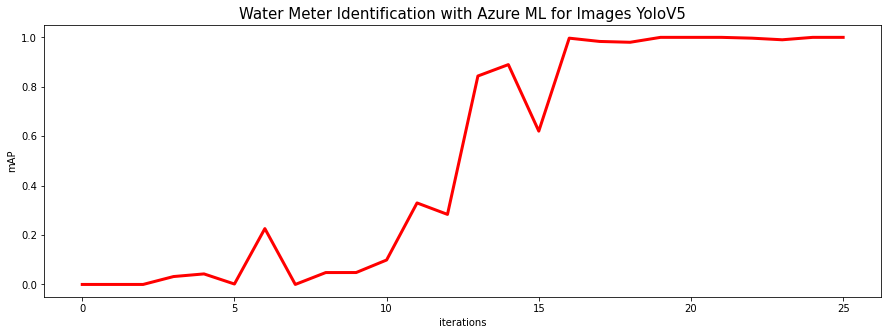

In [61]:
# Let's plot the accuracy metric for the CV model, save the graph to a jpg file and log it to the Azure ML experiment
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (15,5))
plt.plot(automlvisionmetrics['mean_average_precision'], 'r-', lw=3, alpha=1)
plt.xlabel('iterations', fontsize=10)
plt.ylabel('mAP', fontsize=10)
plt.title('Water Meter Identification with Azure ML for Images YoloV5', fontsize=15)

plt.savefig('watermeter_mAP_yolov5.jpg', dpi=150) # Saving image into a jpg file
automl_image_run.log_image(name='watermeter_mAP_yolov5.jpg', plot=plt) # Logging the graph into the Azure ML experiment

plt.show()

In [62]:
!ls watermeter_mAP_yolov5.jpg -l

-rwxrwxrwx 1 root root 102163 Jun 22 12:38 watermeter_mAP_yolov5.jpg


## 7. Register the optimal model from the AutoML run
Once the run completes, we can register the model that was created from the best run (configuration that resulted in the best primary metric)

In [63]:
# Defining tags for the custom vision model
cvmodel_tags={"Data": "Images", 
              "Context" : "Water Meter Index Recognition",
              "Computer Vision" : "True",
              "Task" : "Best AutoML Images",
              "Framework" : "Yolo V5 AutoML for Images",
              "AutoML Metric" : "mAP"}

In [64]:
# Register the model from the best run
best_child_run = automl_image_run.get_best_child()
model_name = best_child_run.properties['model_name']

model = best_child_run.register_model(model_name = model_name, 
                                      model_path='outputs/model.pt',
                                      tags=cvmodel_tags,
                                      description="Water Meter Index detection")

In [65]:
model

Model(workspace=Workspace.create(name='automlvision', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='automlvision-rg'), name=AutoML93fc122240, id=AutoML93fc122240:1, version=1, tags={'Data': 'Images', 'Context': 'Water Meter Index Recognition', 'Computer Vision': 'True', 'Task': 'Best AutoML Images', 'Framework': 'Yolo V5 AutoML for Images', 'AutoML Metric': 'mAP'}, properties={})

In [66]:
model.id

'AutoML93fc122240:1'

In [67]:
model.tags

{'Data': 'Images',
 'Context': 'Water Meter Index Recognition',
 'Computer Vision': 'True',
 'Task': 'Best AutoML Images',
 'Framework': 'Yolo V5 AutoML for Images',
 'AutoML Metric': 'mAP'}

In [68]:
# We can download the CV model
model.download(target_dir='.', exist_ok=True)

'model.pt'

In [69]:
# Checking the PyTorch downloaded file
!ls *.pt -l

-rwxrwxrwx 1 root root 172310912 Jun 22 12:38 model.pt


## 8. Deploy model as a web service
Once you have your trained model, you can deploy the model on Azure. You can deploy your trained model as a web service on Azure Container Instances ([ACI](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-container-instance)) or Azure Kubernetes Service ([AKS](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-kubernetes-service)). ACI is the perfect option for testing deployments, while AKS is better suited for for high-scale, production usage.  
In this tutorial, we will deploy the model as a web service in AKS.

You will need to first create an AKS compute cluster, or use an existing AKS cluster. You can use either GPU or CPU VM SKUs for your deployment cluster

In [70]:
from azureml.core.compute import ComputeTarget, AksCompute
from azureml.exceptions import ComputeTargetException

# Choose a name for your AKS cluster
aks_name = "cluster-aks-gpu"

# Check to see if the cluster already exists
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print("Found existing compute target. So let's use it.")
except ComputeTargetException:
    print('Creating a new compute target...')
    # Provision AKS cluster with GPU machine
    prov_config = AksCompute.provisioning_configuration(vm_size="STANDARD_NC6", 
                                                        location="eastus2")
    # Create the cluster
    aks_target = ComputeTarget.create(workspace=ws, 
                                      name=aks_name, 
                                      provisioning_configuration=prov_config)
    aks_target.wait_for_completion(show_output=True)

Found existing compute target. So let's use it.


In [71]:
aks_target.get_status

<bound method ComputeTarget.get_status of AksCompute(workspace=Workspace.create(name='automlvision', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='automlvision-rg'), name=cluster-aks-gpu, id=/subscriptions/70b8f39e-8863-49f7-b6ba-34a80799550c/resourceGroups/automlvision-rg/providers/Microsoft.MachineLearningServices/workspaces/automlvision/computes/cluster-aks-gpu, type=AKS, provisioning_state=Succeeded, location=westeurope, tags=None)>

> You can see the aks cluster from the Azure ML studio in the **Inference clusters section**.

Next, you will need to define the inference configuration, that describes how to set up the web-service containing your model. You can use the scoring script and the environment from the training run in your inference config. 

> **You can then deploy the model as an AKS web service.**

In [72]:
# Deploy the model from the best run as an AKS web service
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AksWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

best_child_run.download_file('outputs/scoring_file_v_1_0_0.py', output_file_path='score.py')
environment = best_child_run.get_environment()
inference_config = InferenceConfig(entry_script='score.py', environment=environment)

# Name of the service
aks_name='automl-cv-watermeterindex'

# Tags for the service
aks_tags={"Data": "Images", 
          "Topic" : "Water Meter Recognition Custom Vision model", 
          'Task' : 'Object Detection',
          "Framework" : "AutoML Images best model", 
          "AKS" : "True"}

# Description
aks_description="Object Detection CV model to detect water meter index"

# AKS configuration
aks_config = AksWebservice.deploy_configuration(autoscale_enabled=True,                                                    
                                                cpu_cores=1,
                                                memory_gb=50,
                                                enable_app_insights=True, # set to True in order to monitor the service
                                                description=aks_description,
                                                tags=aks_tags)

# Let's deploy now
aks_service = Model.deploy(ws,
                           models=[model],
                           inference_config=inference_config,
                           deployment_config=aks_config,
                           deployment_target=aks_target,
                           name=aks_name,
                           overwrite=True)

aks_service.wait_for_deployment(show_output=True)
print()
print("Done! Model is deployed into AKS.")
print("\nAKS service status=", aks_service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-06-22 12:38:20+00:00 Creating Container Registry if not exists.
2021-06-22 12:38:20+00:00 Registering the environment.
2021-06-22 12:38:21+00:00 Use the existing image..
2021-06-22 12:38:24+00:00 Creating resources in AKS.
2021-06-22 12:38:27+00:00 Submitting deployment to compute.
2021-06-22 12:38:28+00:00 Checking the status of deployment automl-cv-watermeterindex..
2021-06-22 12:38:59+00:00 Checking the status of inference endpoint automl-cv-watermeterindex.
Succeeded
AKS service creation operation finished, operation "Succeeded"

Done! Model is deployed into AKS.

AKS service status= Healthy


## 9. Test the web service
Finally, let's test our deployed web service to predict new images. You can pass in any image.

In [73]:
print("Computer Vision model endpoint:", aks_service.scoring_uri)

Computer Vision model endpoint: http://20.69.208.85:80/api/v1/service/automl-cv-watermeterindex/score


In [74]:
print("Computer Vision model service status=", aks_service.state)

Computer Vision model service status= Healthy


In [75]:
print("Computer Vision model endpoint tags:", aks_service.tags)

Computer Vision model endpoint tags: {'Data': 'Images', 'Topic': 'Water Meter Recognition Custom Vision model', 'Task': 'Object Detection', 'Framework': 'AutoML Images best model', 'AKS': 'True'}


### 9.1 Test 1

In [76]:
# Download image file for testing the model
image_url = 'https://github.com/retkowsky/AutoMLforImages/blob/main/images/watermeter1.jpg?raw=true'
image_file = 'test1.jpg'

urllib.request.urlretrieve(image_url, filename=image_file)
import os.path
if os.path.isfile('test1.jpg'):
    print ("OK: File is available.")

import cv2 as cv
img = cv.imread(image_file)
print("\nImage informations:")
print("- Image filename:", image_file)
print("- Image shape:", img.shape)
print("- Image size:", img.size)

OK: File is available.

Image informations:
- Image filename: test1.jpg
- Image shape: (610, 600, 3)
- Image size: 1098000


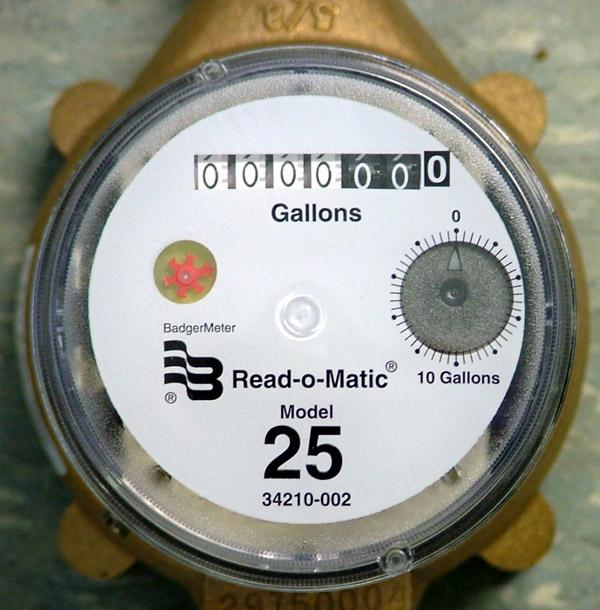

In [77]:
from IPython.display import Image
Image(filename=image_file)

In [78]:
import requests

# URL for the web service
scoring_uri = aks_service.scoring_uri
# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()
# Load image data
data = open(image_file, 'rb').read()
# Set the content type
headers = {'Content-Type': 'application/octet-stream'}
# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'
# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)
print("Status code=",resp.status_code)
print("Elapsed=", resp.elapsed)

Status code= 200
Elapsed= 0:00:00.477911


In [79]:
import json
detections = json.loads(resp.text) # Loadind the predictions from the computer vision model
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']

WaterMeterIndex: [180.047, 152.805, 285.342, 52.11], 0.83


<Figure size 1296x864 with 0 Axes>

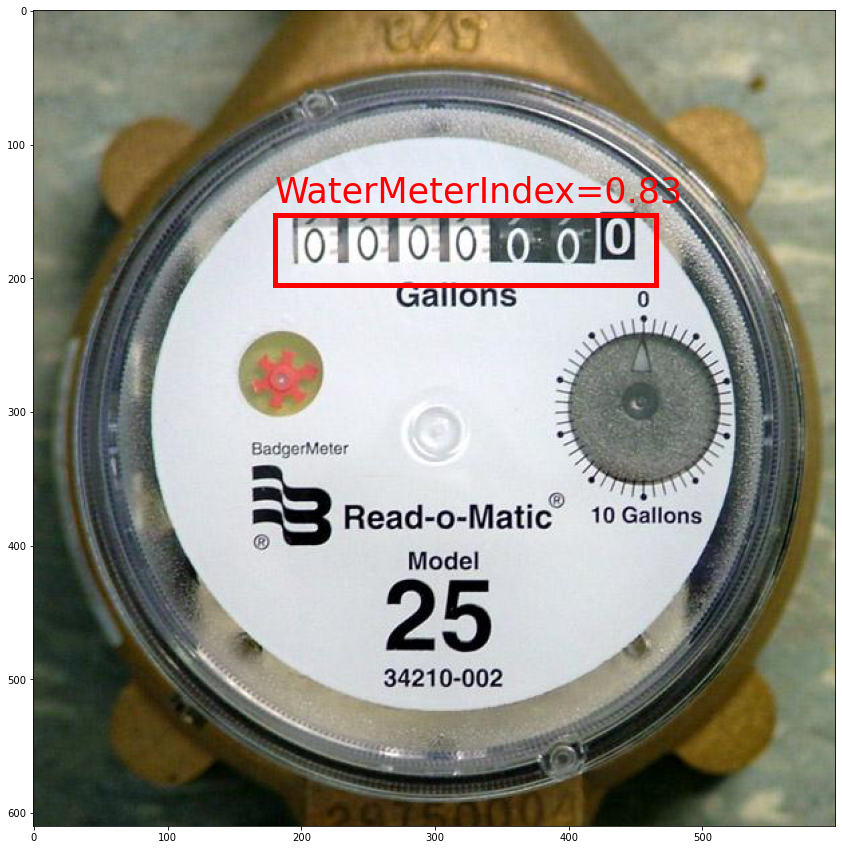

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(image_file)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size

fig,ax = plt.subplots(1, figsize=(15,15)) #You can change the size

# Display the image
ax.imshow(img_np)

minscore=0.5 # Min value

# draw box and label for each detection 
detections = json.loads(resp.text) # Loadind the predictions from the computer vision model
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']
    if conf_score >= minscore: #Min probability
        ymin, xmin, ymax, xmax =  box['topY'],box['topX'], box['bottomY'],box['bottomX']
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print('{}: [{}, {}, {}, {}], {}'.format(detect['label'], round(topleft_x, 3), 
                                                round(topleft_y, 3), round(width, 3), 
                                                round(height, 3), round(conf_score, 3)))

        color = 'red' #You can change the color
        rect = patches.Rectangle((topleft_x, topleft_y), width, height, 
                                 linewidth=5, edgecolor=color,facecolor='none')
        textdisp=label+'='+str(round(conf_score, 2))
        ax.add_patch(rect)
        plt.text(topleft_x, topleft_y - 10, textdisp, color=color, fontsize=35)
        
        fig.savefig('predictiontest1.jpg', dpi=150) #Saving image
        
plt.show()

### 9.2 Test 2

In [81]:
image_url = 'https://github.com/retkowsky/AutoMLforImages/blob/main/images/watermeter2.jpg?raw=true'
image_file = 'test2.jpg'
urllib.request.urlretrieve(image_url, filename=image_file)

import os.path
if os.path.isfile('test2.jpg'):
    print ("OK: File is there.")
    
img = cv.imread(image_file)
print("\nImage informations:")
print("- Image filename:", image_file)
print("- Image shape:", img.shape)
print("- Image size:", img.size)

OK: File is there.

Image informations:
- Image filename: test2.jpg
- Image shape: (2399, 2930, 3)
- Image size: 21087210


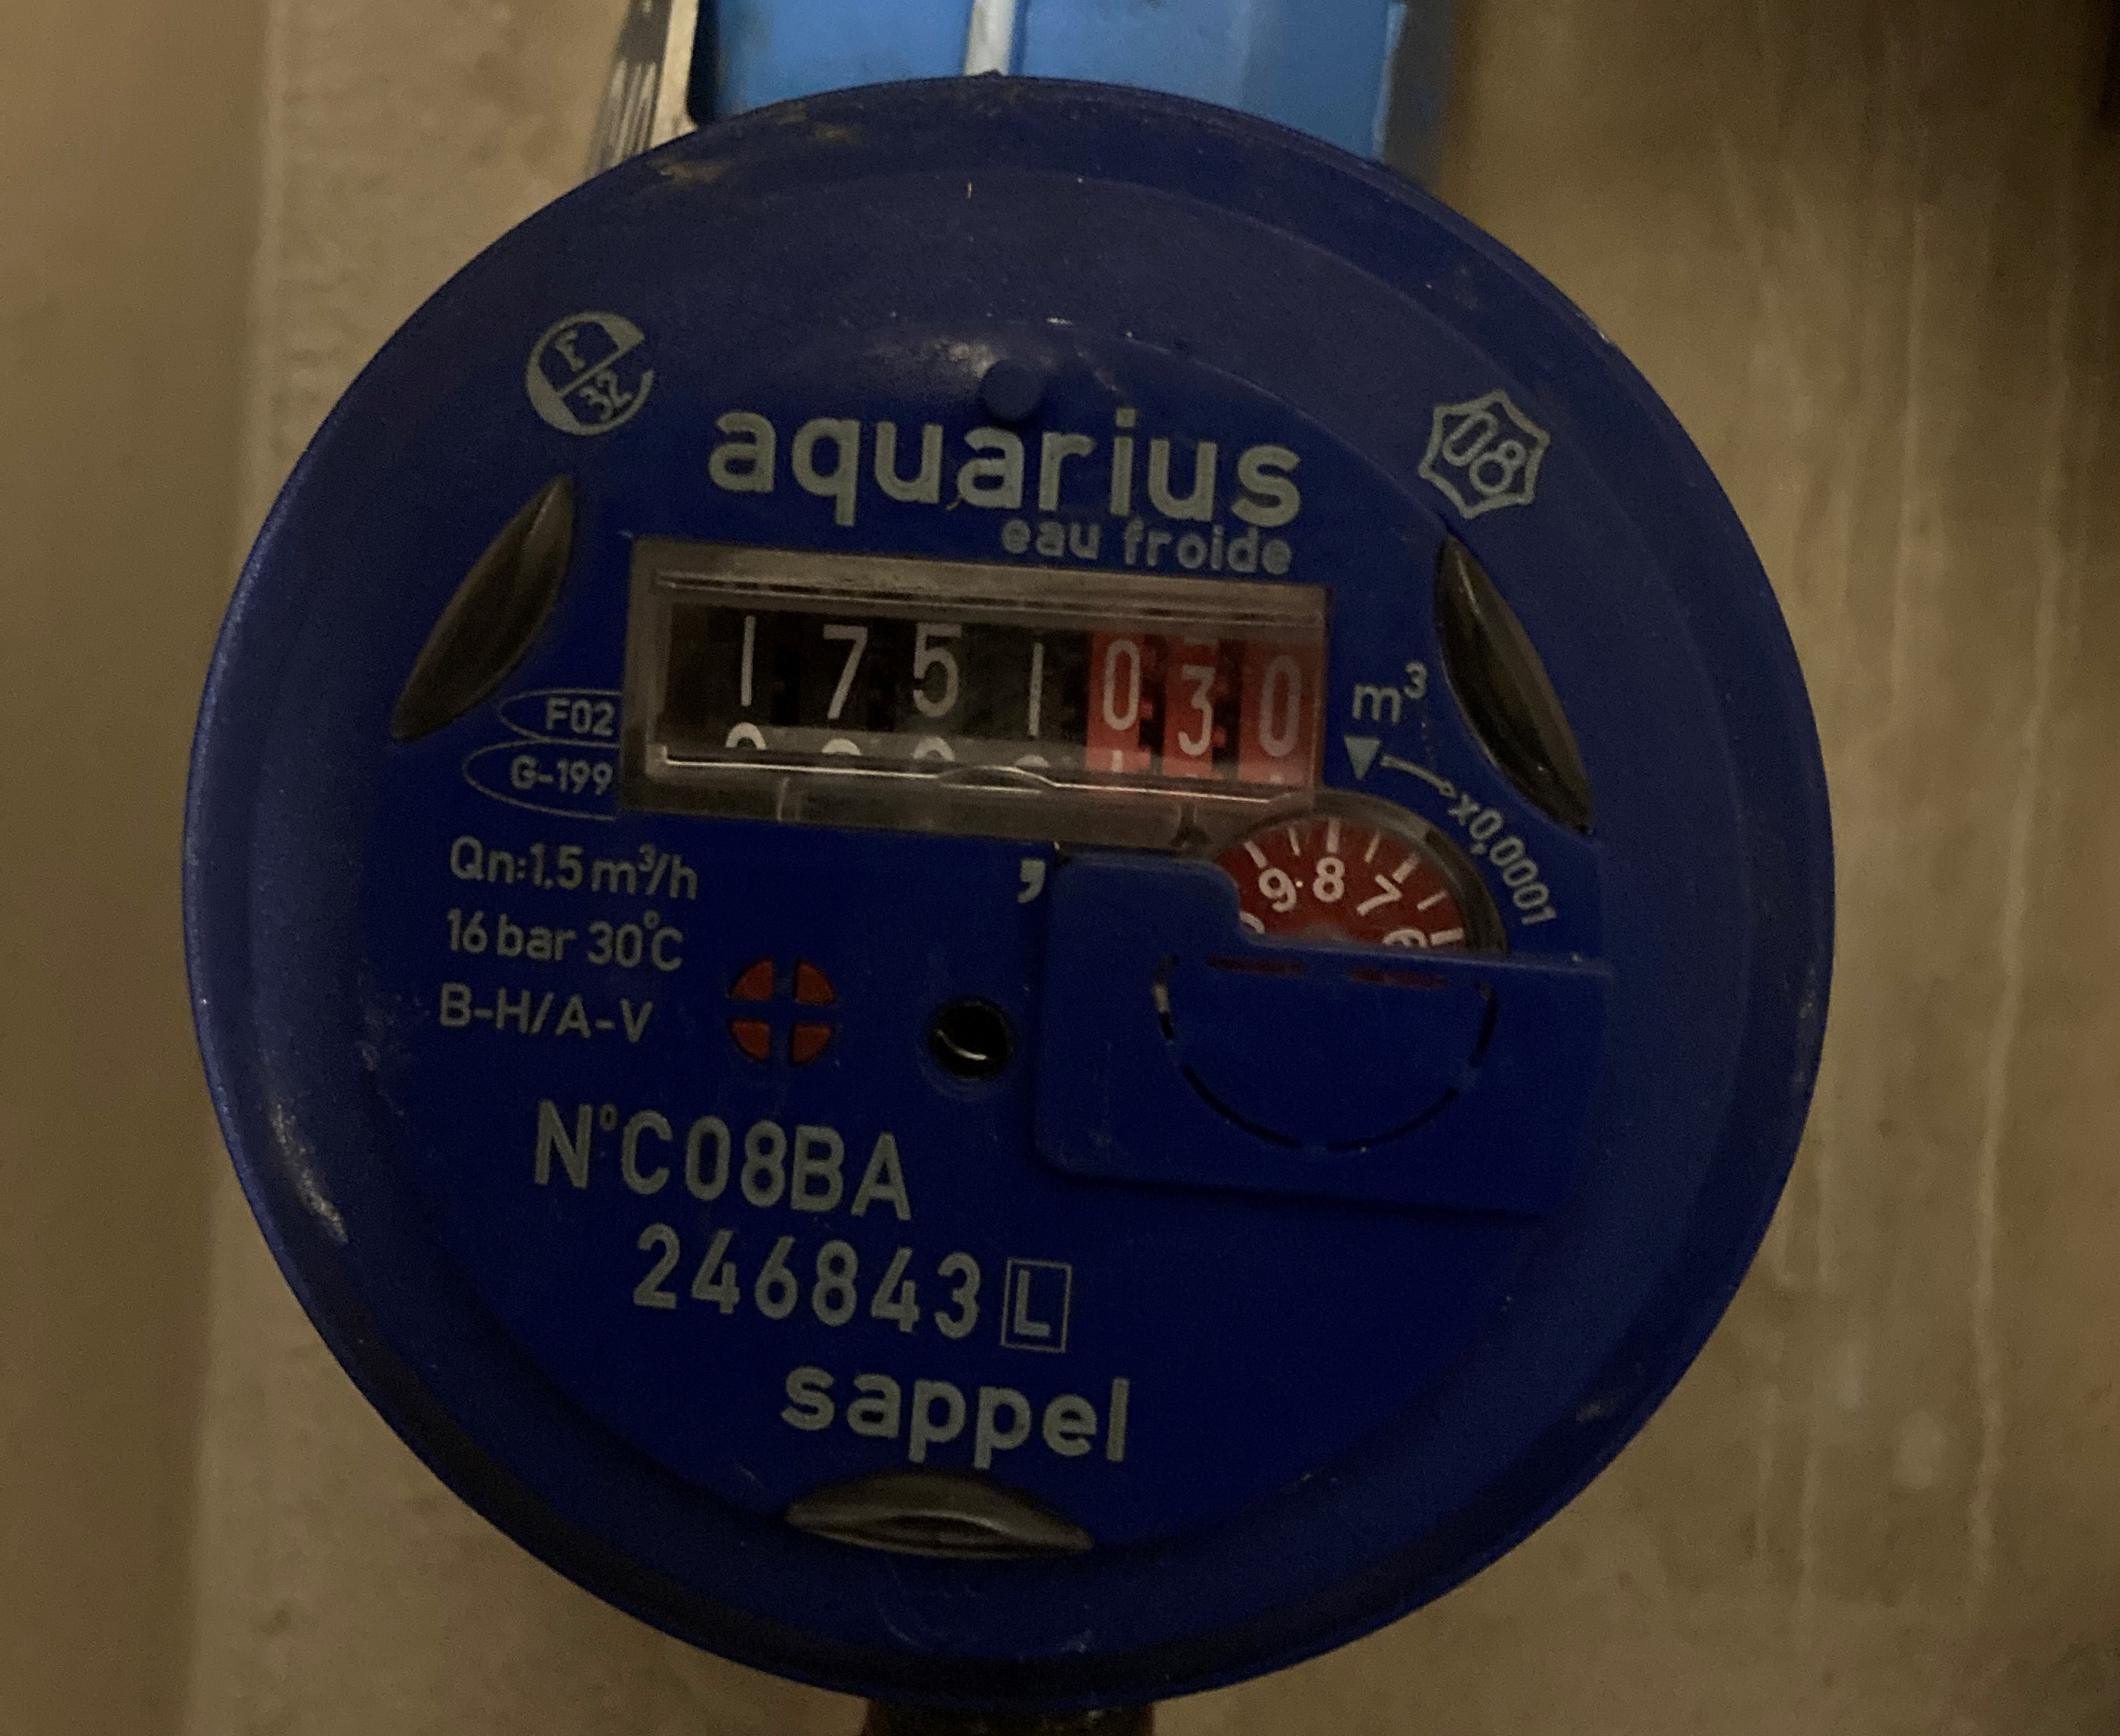

In [82]:
from IPython.display import Image
Image(filename=image_file)

In [83]:
import requests

# URL for the web service
scoring_uri = aks_service.scoring_uri
# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()
# Load image data
data = open(image_file, 'rb').read()
# Set the content type
headers = {'Content-Type': 'application/octet-stream'}
# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'
# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)
print("Status code=",resp.status_code)
print("Elapsed=", resp.elapsed)

Status code= 200
Elapsed= 0:00:00.939380


In [84]:
import json
detections = json.loads(resp.text) # Loadind the predictions from the computer vision model
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']

WaterMeterIndex: [781.161, 784.745, 1151.589, 323.717], 0.935


<Figure size 1296x864 with 0 Axes>

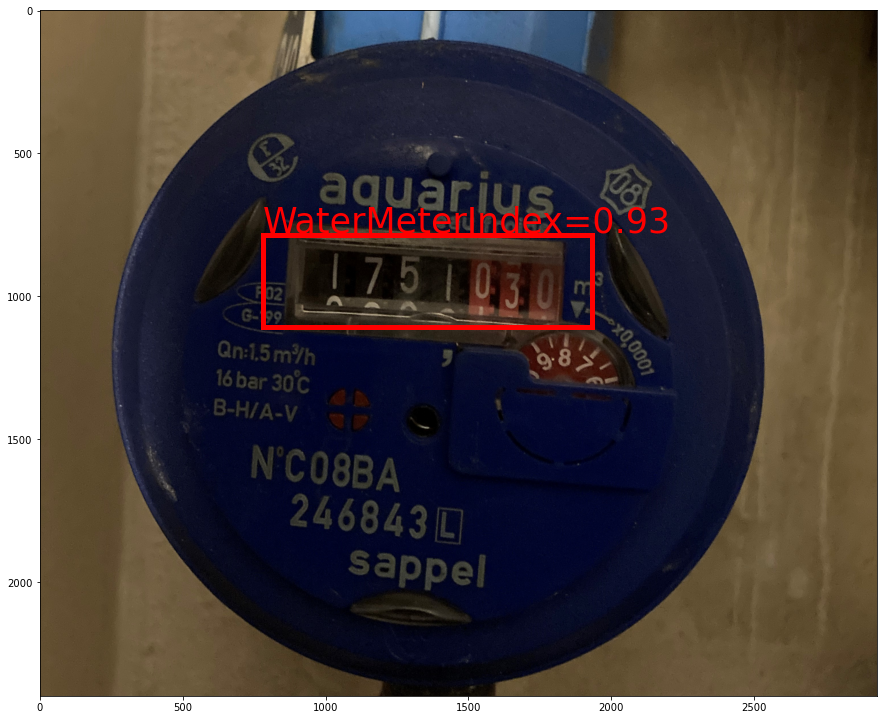

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(image_file)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size

fig,ax = plt.subplots(1, figsize=(15,15)) #You can change the size

# Display the image
ax.imshow(img_np)

minscore=0.5

# draw box and label for each detection 
detections = json.loads(resp.text) # Loadind the predictions from the computer vision model
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']
    if conf_score >= minscore: #Min probability
        ymin, xmin, ymax, xmax =  box['topY'],box['topX'], box['bottomY'],box['bottomX']
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print('{}: [{}, {}, {}, {}], {}'.format(detect['label'], round(topleft_x, 3), 
                                                round(topleft_y, 3), round(width, 3), 
                                                round(height, 3), round(conf_score, 3)))

        color = 'red' #You can change the color
        rect = patches.Rectangle((topleft_x, topleft_y), width, height, 
                                 linewidth=5, edgecolor=color,facecolor='none')
        textdisp=label+'='+str(round(conf_score, 2))
        ax.add_patch(rect)
        plt.text(topleft_x, topleft_y - 10, textdisp, color=color, fontsize=35)
        
        fig.savefig('predictiontest2.jpg', dpi=150) #Saving image
        
plt.show()

## 10. Let's use Azure OCR to identify the water meter index

In [86]:
image_url = 'https://github.com/retkowsky/AutoMLforImages/blob/main/images/watermeter3.jpg?raw=true'
image_file = 'test3.jpg'
urllib.request.urlretrieve(image_url, filename=image_file)

import os.path
if os.path.isfile('test3.jpg'):
    print ("File is downloaded. OK.")

img = cv.imread(image_file)
print("\nImage informations:")
print("- Image filename:", image_file)
print("- Image shape:", img.shape)
print("- Image size:", img.size)

File is downloaded. OK.

Image informations:
- Image filename: test3.jpg
- Image shape: (400, 740, 3)
- Image size: 888000


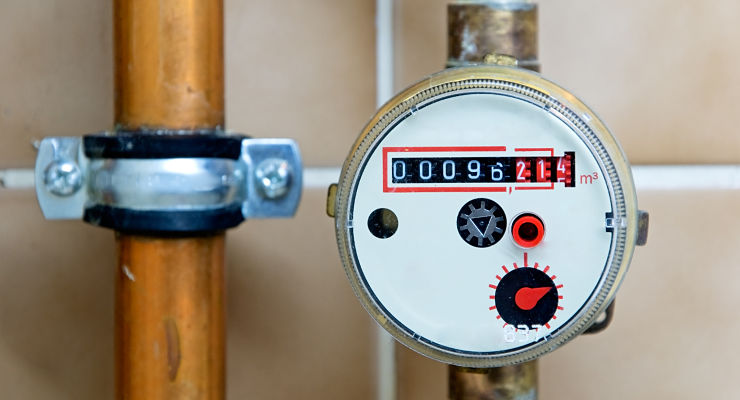

In [87]:
from IPython.display import Image
Image(filename=image_file)

In [88]:
# URL for the web service
scoring_uri = aks_service.scoring_uri
# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()
# Load image data
data = open(image_file, 'rb').read()
# Set the content type
headers = {'Content-Type': 'application/octet-stream'}
# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'
# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)

In [89]:
detections = json.loads(resp.text) # Loadind the predictions from the computer vision model
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']

WaterMeterIndex: [368.866, 149.437, 225.335, 44.629], 0.873


<Figure size 1296x864 with 0 Axes>

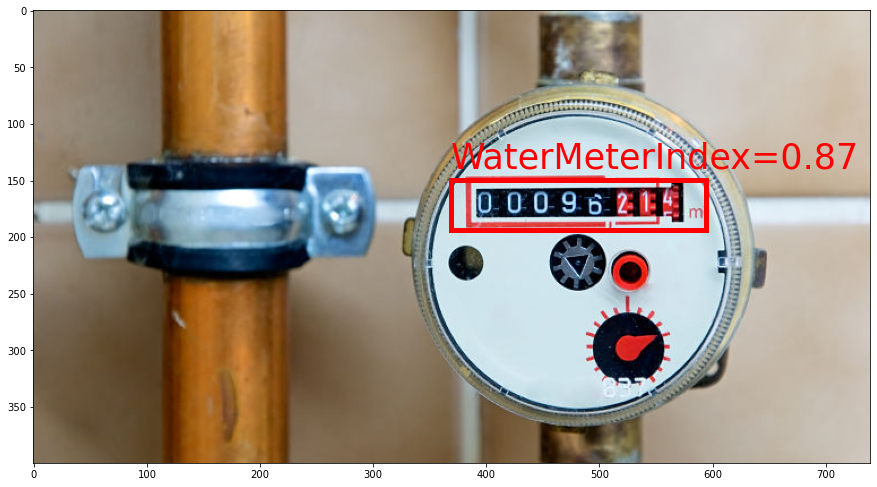

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(image_file)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size

fig,ax = plt.subplots(1, figsize=(15,15)) #You can change the size

# Display the image
ax.imshow(img_np)

minscore=0.5

# draw box and label for each detection 
detections = json.loads(resp.text) # Loadind the predictions from the computer vision model
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']
    if conf_score >= minscore: #Min probability
        ymin, xmin, ymax, xmax =  box['topY'],box['topX'], box['bottomY'],box['bottomX']
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print('{}: [{}, {}, {}, {}], {}'.format(detect['label'], round(topleft_x, 3), 
                                                round(topleft_y, 3), round(width, 3), 
                                                round(height, 3), round(conf_score, 3)))

        color = 'red' #You can change the color
        rect = patches.Rectangle((topleft_x, topleft_y), width, height, 
                                 linewidth=5, edgecolor=color,facecolor='none')
        textdisp=label+'='+str(round(conf_score, 2))
        ax.add_patch(rect)
        plt.text(topleft_x, topleft_y - 10, textdisp, color=color, fontsize=35)
        
        fig.savefig('predictiontest3.jpg', dpi=150) #Saving image
        
plt.show()

### Only the water meter

In [190]:
x1=round(topleft_x)
y1=round(topleft_y)
x2=x1+round(width)
y2=y1+round(height)

In [191]:
import cv2
img = cv2.imread(image_file)

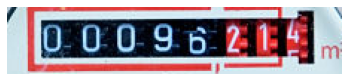

In [192]:
watermeterfile="indexcolor.jpg" #Name of the cropping image
plt.axis('off')
watermeter= img[y1:y2, x1:x2] #Cropping image
plt.imshow(cv2.cvtColor(watermeter, cv2.COLOR_BGR2RGB))
plt.savefig(watermeterfile, dpi=150) #Saving image

### Azure OCR

In [193]:
#!pip install azure-cognitiveservices-vision-computervision

In [194]:
ocr_key = 'yourkey'
ocr_endpoint = 'yourendpoint'

Azure OCR results :
Index read =  00096214

=> Meter Index = 96.214 M3 of water
= 96214 liters of water


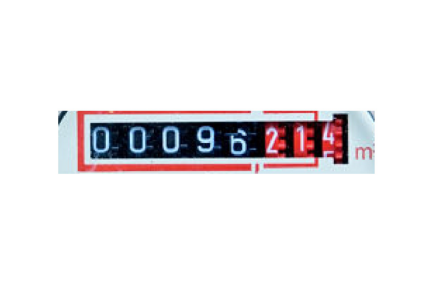

In [220]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from msrest.authentication import CognitiveServicesCredentials
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
%matplotlib inline

# Read the image file
image_path = os.path.join('indexcolor.jpg')
image_stream = open(image_path, "rb")

# Get a client for the computer vision service
computervision_client = ComputerVisionClient(ocr_endpoint, CognitiveServicesCredentials(ocr_key))

# Submit a request to read printed text in the image and get the operation ID
read_operation = computervision_client.read_in_stream(image_stream,
                                                      raw=True)
operation_location = read_operation.headers["Operation-Location"]
operation_id = operation_location.split("/")[-1]

# Wait for the asynchronous operation to complete
while True:
    read_results = computervision_client.get_read_result(operation_id)
    if read_results.status not in [OperationStatusCodes.running]:
        break
    time.sleep(1)

# If the operation was successfuly, process the text line by line
if read_results.status == OperationStatusCodes.succeeded:
    for result in read_results.analyze_result.read_results:
        for line in result.lines:
            if len(line.text)==8: #Expected length of index
                index=int(line.text)/1000
                print("Azure OCR results :")
                print("Index read = ", line.text)
                print("\n\033[1;31;34m=> Meter Index =", index,'M3 of water')
                print("\033[1;31;34m=", round(index*1000),'liters of water')
# Open image and display it.
fig = plt.figure(figsize=(10,5))
img = Image.open(image_path)
plt.axis('off')
plt.imshow(img)

## 11. Cleanup ressources

In [221]:
# Let's delete the service
aks_service.delete()

In [222]:
# Let's delete our Azure ML GPU compute cluster
compute_target.delete()